In [1]:
# import
import os
import math
import joblib
import numpy as np
import pandas as pd
import geopandas as gpd
import plotly.express as px
from shapely import geometry
from sklearn import metrics
from kneed import KneeLocator
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from IPython.display import display
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split


/Users/mac/Desktop/2R/env/lib/python3.8/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.0-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
def load_dataset(data_csv, keep_cols) :
    # load
    df = pd.read_csv(data_csv, index_col=[0])

    # necessary columns
    df_reduced = df[keep_cols]

    # display
    print("dataset sample :")
    display(df_reduced.sample(2))

    print("dataset shape :")
    display(df_reduced.shape)
    return df_reduced


## RUN
accidents_csv = "../../db/shared/accidents_2R_75.csv"
keep_cols = ["lat", "long", "catv"]
accidents_df = load_dataset(accidents_csv, keep_cols)

dataset sample :


,lat,long,catv
4181,48.872081,2.275530,1
2339,48.844342,2.441648,34


dataset shape :


(4480, 3)

In [3]:
def cleanup_dataset(df) :
    # drop na
    df = df.dropna()

    # verify lat
    df = df.loc[df.lat <= 90.0]
    df = df.loc[df.lat >= -90.0]

    # verify lon
    df = df.loc[df.long <= 180.0]
    df = df.loc[df.long >= -180.0]

    # return
    return df

## RUN 
accidents_df = cleanup_dataset(accidents_df)

In [4]:
def create_radian_columns(df, lon_col, lat_col):
    # new col name
    rad_lon = "rad_" + lon_col
    rad_lat = "rad_" + lat_col


    df[rad_lon] = np.radians(df[lon_col].values)
    df[rad_lat] = np.radians(df[lat_col].values)
    return df, rad_lat, rad_lon

## RUN
lon_col = "long"
lat_col = "lat"
accidents_df, rad_lat, rad_lon = create_radian_columns(accidents_df, lon_col, lat_col)
accidents_df

,lat,long,catv,rad_long,rad_lat
0,48.883074,2.283707,33,0.039858,0.853171
1,48.847048,2.411057,33,0.042081,0.852542
2,48.872928,2.408648,33,0.042039,0.852994
3,48.856564,2.394438,33,0.041791,0.852708
4,48.891922,2.398340,32,0.041859,0.853325
...,...,...,...,...,...
4475,48.848598,2.372486,1,0.041408,0.852569
4476,48.864450,2.378830,33,0.041518,0.852846
4477,48.868801,2.367627,30,0.041323,0.852921
4478,48.856920,2.291953,43,0.040002,0.852714


In [5]:
def df_to_cluster(df, lat_col, lon_col) :
    return df[[lat_col, lon_col]]

accidents_for_model = df_to_cluster(accidents_df, rad_lat, rad_lon)
accidents_for_model

,rad_lat,rad_long
0,0.853171,0.039858
1,0.852542,0.042081
2,0.852994,0.042039
3,0.852708,0.041791
4,0.853325,0.041859
...,...,...
4475,0.852569,0.041408
4476,0.852846,0.041518
4477,0.852921,0.041323
4478,0.852714,0.040002


In [6]:
def cluster_model(df, hyperparam):

    # read hyperparameters
    eps_in_meters = hyperparam["eps_in_meters"]
    num_samples = hyperparam["num_samples"]
    metric_dist = hyperparam["metric_dist"]
    algorithm = hyperparam["algorithm"]

    # eps in radians
    earth_perimeter = 40070000.0  # In meters
    eps_in_radians = eps_in_meters / earth_perimeter * (2 * math.pi)

    db_scan = DBSCAN(eps=eps_in_radians, 
                     min_samples=num_samples, 
                     metric=metric_dist,
                     algorithm=algorithm)
    db_scan.fit(df[["rad_lat", "rad_long"]])

    # fit - clusters
    # df["cluster"] = db_scan.fit_predict(df)
    df["cluster"] = db_scan.labels_

    # metrics
    sil_score = round(metrics.silhouette_score(df[["rad_lat", "rad_long"]], df['cluster']), 3)
    print(f"Score : {sil_score}")

    # return
    return df, db_scan

## RUN
hyperparam = {
    "eps_in_meters" : 50,
    "num_samples" : 5,
    "metric_dist" : "haversine",
    "algorithm" : "ball_tree"
}

accidents_df_1, db_scan = cluster_model(accidents_df, hyperparam)
display(len(set(accidents_df_1["cluster"])))
display(accidents_df_1.groupby(["cluster"]).count().head())

Score : -0.553


145

,lat,long,catv,rad_long,rad_lat
cluster,,,,,
-1,3578,3578,3578,3578,3578
0,8,8,8,8,8
1,8,8,8,8,8
2,7,7,7,7,7
3,5,5,5,5,5


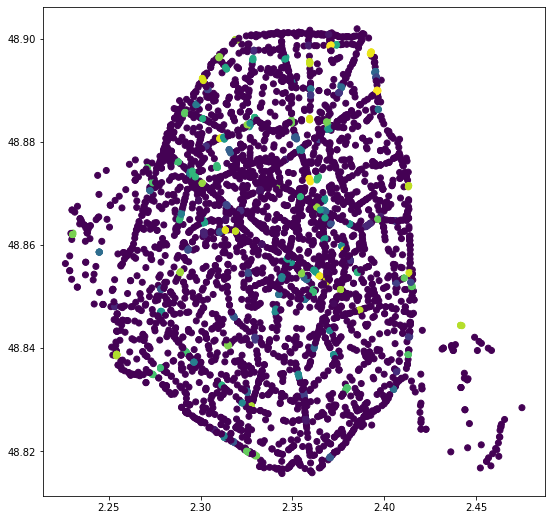

In [7]:
def plot_clusters(df) :
    """plot clusters
    """

    plt.figure(figsize=(9,9))
    plt.scatter(df["long"], df["lat"], c=df["cluster"])
    plt.show()

## RUN
mask = accidents_df_1["cluster"].isin([-1])
df_to_plot = accidents_df_1[~mask]
plot_clusters(accidents_df_1)

In [8]:
def eps_in_meters(eps_in_radians) :
    earth_perimeter = 40070000.0  # In meters
    eps_in_meters = eps_in_radians * earth_perimeter / (2 * math.pi)
    return round(eps_in_meters,4)

'neighbors: 5, eps elbow (m): 421.0644'

None

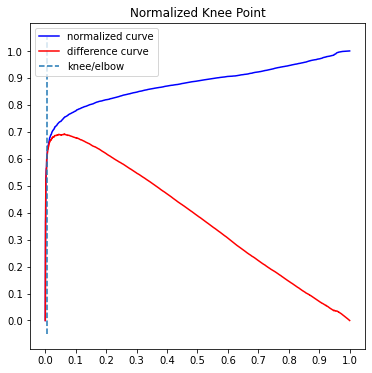

In [9]:
def kneed_tune_eps_hyperparam(df, n_neighbors) :
    # Nearestneighbors model
    nbrs = NearestNeighbors(n_neighbors=neighbors, metric="haversine").fit(df)

    # get distance
    distances, indices = nbrs.kneighbors(df)

    # distance in desc order
    distance_desc = sorted(distances[:,neighbors-1], reverse=True)

    # search elbow
    kneedle = KneeLocator(range(1,len(distance_desc)+1),  #x values
                      distance_desc, # y values
                      S=1.0, #parameter suggested from paper
                      curve="convex", #parameter from figure
                      direction="decreasing") #parameter from figure

    # eps elbow
    eps_elbow = kneedle.knee_y

    ## eps elbow in meter
    eps_elbow_m = eps_in_meters(eps_elbow)
    display(f"neighbors: {n_neighbors}, eps elbow (m): {eps_elbow_m}")

    # plot
    display(px.line(x=list(range(1,len(distance_desc )+1)),y= distance_desc))
    display(kneedle.plot_knee_normalized())

    # return 
    return eps_elbow_m
    

## RUN
neighbors = 5
eps_elbow_m = kneed_tune_eps_hyperparam(accidents_for_model, neighbors)


Score : 0.145


8

,lat,long,catv,rad_long,rad_lat
cluster,,,,,
-1,11,11,11,11,11
0,4379,4379,4379,4379,4379
1,45,45,45,45,45
2,8,8,8,8,8
3,18,18,18,18,18


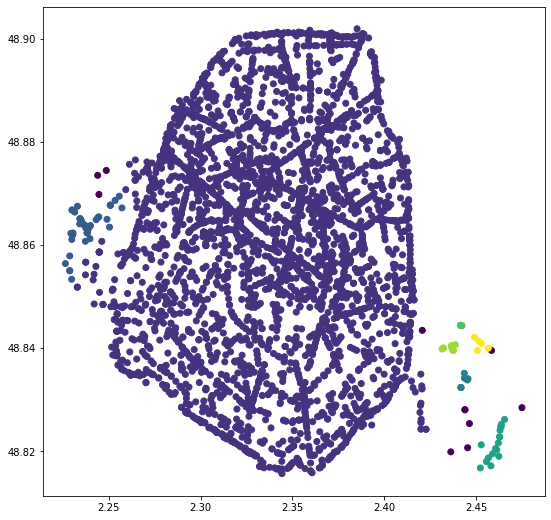

In [10]:
hyperparam_tune = {
    "eps_in_meters" : eps_elbow_m,
    "num_samples" : neighbors,
    "metric_dist" : "haversine",
    "algorithm" : "ball_tree"
}

accidents_df_tune, db_scan = cluster_model(accidents_df, hyperparam_tune)
display(len(set(accidents_df_tune["cluster"])))
display(accidents_df_tune.groupby(["cluster"]).count().head())

mask = accidents_df_tune["cluster"].isin([-1])
df_to_plot = accidents_df_tune[~mask]
plot_clusters(accidents_df_tune)

Score : -0.593


'Eps : 45'

'Number of clusters : 128'

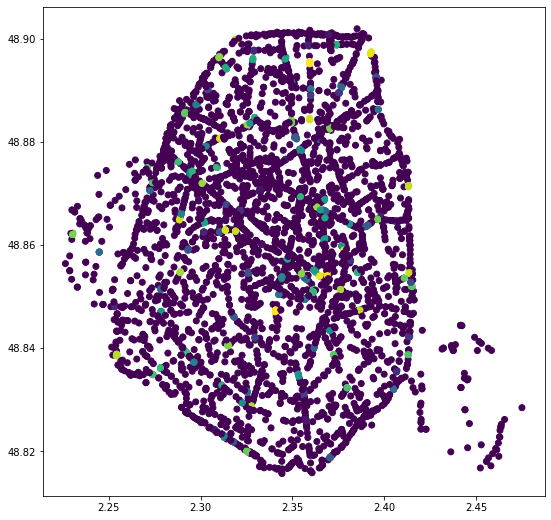

None

Score : -0.553


'Eps : 50'

'Number of clusters : 145'

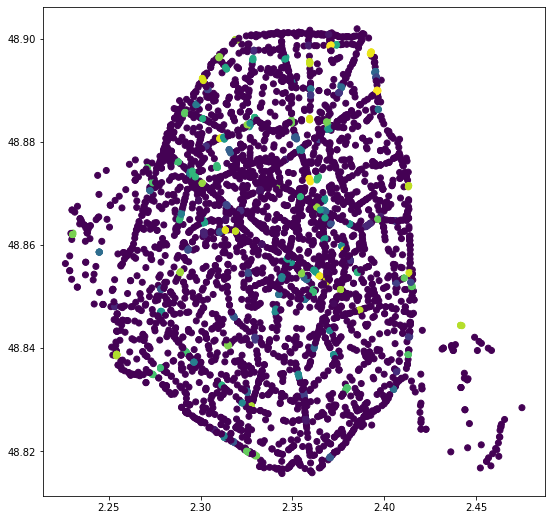

None

In [11]:
def loop_tune_eps_hyperparam(df, n_neighbors, range) :
    # loop through range
    for eps in range : 

        hyperparam = {
        "eps_in_meters" : eps,
        "num_samples" : n_neighbors,
        "metric_dist" : "haversine",
        "algorithm" : "ball_tree"
        }

        try : 
            df_eps_tune, db_scan = cluster_model(df, hyperparam)
            n_clusters = len(set(df_eps_tune["cluster"]))
            display(f"Eps : {eps}")
            display(f"Number of clusters : {n_clusters}")          
        except :
            print(f"cluster < 2 for eps : {eps}")

        # plot
        mask = df_eps_tune["cluster"].isin([-1])
        df_to_plot = df_eps_tune[~mask]
        display(plot_clusters(df_eps_tune))

## RUN
list_eps = range(45,55,5)
num_samples_fixed = 5

loop_tune_eps_hyperparam(accidents_df, num_samples_fixed, list_eps)

Score : -0.086
model_cluster/model.joblib exists !
model_cluster/cluster_points.geojson exists !


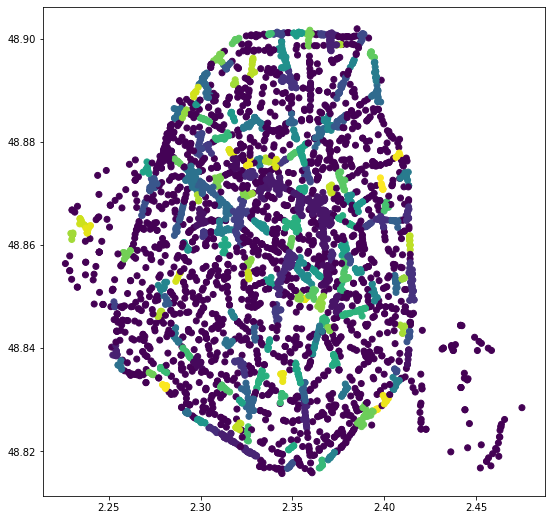

In [12]:
def model(df, tune_hyperparam, col_order, overwrite) :
    # fit model
    df, db_scan = cluster_model(df, tune_hyperparam)

    ## SAVE MODEL
    # mkdir
    deliv_dir = "model_cluster"
    if not os.path.exists(deliv_dir) : 
        os.mkdir("model_cluster")

    ## SAVE CLUSTER POINTS
    # save_model
    model_file = deliv_dir + "/model.joblib"
    if not os.path.exists(model_file) or overwrite==True : 
        joblib.dump(db_scan, model_file)
        print(f"{model_file} exported !")
    else : 
        print(f"{model_file} exists !")

    # cluster to geodataframe
    df_cluster = df.copy()
    gdf_cluster = gpd.GeoDataFrame(df_cluster, 
                    geometry=gpd.points_from_xy(df_cluster.long, df_cluster.lat),
                    crs="epsg:4326")

    # arrange col order
    gdf_cluster = gdf_cluster[col_order]

    # mask on class -1
    mask = gdf_cluster["cluster"].isin([-1])
    gdf_cluster = gdf_cluster[~mask]

    # save to cluster_point_file
    cluster_points_file = deliv_dir + "/cluster_points.geojson"
    if not os.path.exists(cluster_points_file) or overwrite==True : 
        gdf_cluster.to_file(cluster_points_file)
        print(f"{cluster_points_file} exported !")

    else : 
        print(f"{cluster_points_file} exists !")

    return model_file, cluster_points_file, df_cluster

## RUN
df = accidents_df
tune_hyperparam = {
        "eps_in_meters" : 50,
        "num_samples" : 5,
        "metric_dist" : "haversine",
        "algorithm" : "ball_tree"
}
tune_hyperparam = {
    "eps_in_meters" : 140,
    "num_samples" : 7,
    "metric_dist" : "haversine",
    "algorithm" : "ball_tree"
}

overwrite = False
keep_col = ["cluster", "catv", "lat", "long", "rad_lat", "rad_long", "geometry"]
model_file, cluster_points_file, df_cluster = model(df, tune_hyperparam, keep_col, overwrite)
plot_clusters(df_cluster)
    

In [13]:
def blob_cluster(cluster_points_file, overwrite=False) :

    # read cluster gdf
    gdf_cluster = gpd.read_file(cluster_points_file)

    # cluster index
    cluster_indexes = list(set(gdf_cluster["cluster"]))
    gdf_cluster_list = []

    for cluster_idx in cluster_indexes : 
        # None
        number_accidents = 0

        # recup cluster group
        mask_cluster = gdf_cluster["cluster"] == cluster_idx
        gdf_cluster_group = gdf_cluster[mask_cluster]
        number_accidents = gdf_cluster_group.shape[0]

        # cluster_group_gdf.shape[0] > 10
        if  cluster_idx!=-1:
            # init
            dict_template = None
            
            # new cluster
            dict_template = {
                "cluster_index":cluster_idx,
                "n_accidents":number_accidents
            }
            df_cluster = pd.DataFrame([dict_template])

            # create polygons from list of point 
            list_geometry = gdf_cluster_group["geometry"].to_list()
            poly = geometry.Polygon([[p.x, p.y] for p in list_geometry])

            # take polygons cover
            # cluster_cover = poly
            cluster_cover = poly.convex_hull

            # covert to gdf
            df_cluster["geometry"] = cluster_cover
            cluster_cover_gdf = gpd.GeoDataFrame(df_cluster, geometry=df_cluster["geometry"], crs="epsg:4326")
            #display(cluster_cover_gdf)

            # saved
            #cluster_cover_gdf.to_file(f"./clusters/cluster_polygons_{str(cluster_idx)}.geojson")
            # add
            gdf_cluster_list.append(cluster_cover_gdf)

    # merge geodataframe
    clusters_all_gdf = pd.concat(gdf_cluster_list, axis=0, ignore_index=True)
    clusters_all_gdf = clusters_all_gdf.reset_index(drop=True)

    # save all as cluster_polygon
    # mkdir
    deliv_dir = "model_cluster"
    # if not os.path.exists(deliv_dir) : 
    #     os.mkdir("model_cluster")

    ## SAVE CLUSTER POLYGONS
    # save cluster polygons
    cluster_polygons_file = deliv_dir + "/cluster_polygons.geojson"

    if not os.path.exists(cluster_polygons_file) or overwrite==True : 
        clusters_all_gdf.to_file(cluster_polygons_file)
        print(f"{cluster_polygons_file} exported !")

    else : 
        print(f"{cluster_polygons_file} exists !")
    
    # return
    return clusters_all_gdf, cluster_polygons_file


## RUN
overwrite = True
clusters_all_gdf, cluster_polygons_file = blob_cluster(cluster_points_file, overwrite)
display(clusters_all_gdf.sample(2))

model_cluster/cluster_polygons.geojson exported !


,cluster_index,n_accidents,geometry
98,98,6,"POLYGON ((2.27821 48.83601, 2.27821 48.83601, ..."
51,51,5,"POLYGON ((2.35758 48.85322, 2.35782 48.85334, ..."


In [14]:
clusters_all_gdf.min()

/var/folders/04/nhkbrdrd3453482rr7w_x_mc0000gn/T/ipykernel_17116/1925530441.py:1: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



cluster_index    0
n_accidents      5
dtype: int64

In [15]:
import folium 
#localisation Paris
m = folium.Map(location=[48.862, 2.346], tiles='cartodbpositron', zoom_start=11)

In [16]:
gdf = clusters_all_gdf.copy()
for _, r in gdf.iterrows():
    # Without simplifying the representation of each borough,
    # the map might not be displayed
    sim_geo = gpd.GeoSeries(r['geometry']).simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j,
                           style_function=lambda x: {'fillColor': '#ff0000'})
    folium.Popup(r['n_accidents']).add_to(geo_j)
    geo_j.add_to(m)

In [17]:
m